# 오픈포즈 추론

In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [2]:
from utils.openpose_net import OpenPoseNet

# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터 읽어오기
net_weights = torch.load("./weights/pose_model_scratch.pth", map_location={"cuda:0":"cpu"})
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 net.state_dict().keys()로 복사
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]

# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print("네트워크 설정 완료: 학습된 가중치를 로드했습니다")

네트워크 설정 완료: 학습된 가중치를 로드했습니다


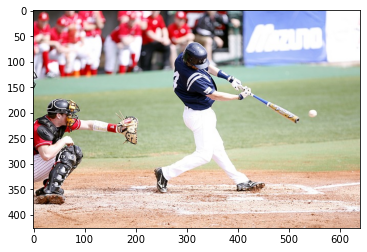

In [3]:
# 전처리
test_image = "./data/hit-1407826_640.jpg"
oriImg = cv2.imread(test_image)

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

size = (368,368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 화상 전처리
img = img.astype(np.float32) / 255.

color_mean = [ 0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:,:,::-1]

for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]

img = preprocessed_img.transpose((2,0,1)).astype(np.float32)

img = torch.from_numpy(img)

x = img.unsqueeze(0)

In [4]:
# 오픈포즈로 히트맵과 PAFs를 구한다

net.eval()
predicted_outputs, _ = net(x)

pafs = predicted_outputs[0][0].detach().numpy().transpose(1,2,0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1,2,0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

/home/plass-heesu/.conda/envs/tf2.5/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


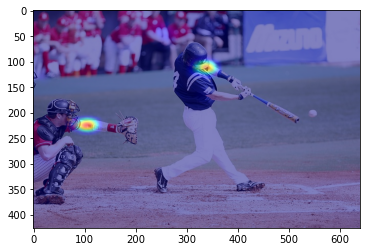

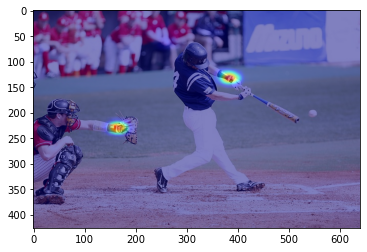

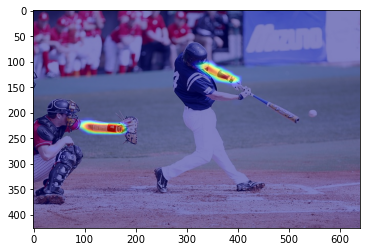

In [5]:
heat_map = heatmaps[:,:,6]

heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert("RGB"))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

heat_map = heatmaps[:,:,7]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)* 255))
heat_map = np.asarray(heat_map.convert("RGB"))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5,0)
plt.imshow(blend_img)
plt.show()

paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert("RGB"))

blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [6]:
from utils.decode_pose import decode_pose

_, result_img ,_ ,_ = decode_pose(oriImg, heatmaps, pafs)

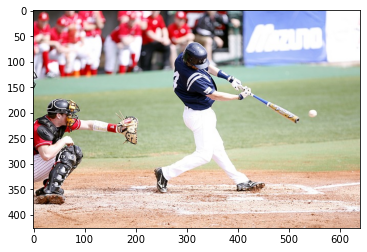

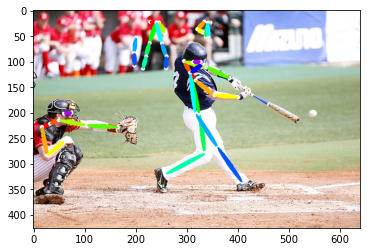

In [7]:
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()